In [1]:
#Optimising hyperparameters

import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame

In [2]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth, gauss):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': gauss,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
    return full_spec, iso


def splitter(tr_f, no_sparse, full_spec, iso):
    #Randomly choosing representative matrix
    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #representative/sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel


In [ ]:
def cut_off_opt(cat, cut_start, cut_finish, cut_interval, smo_cut, sparse_size, 
                ker_exp, reg):
    cut_offs = list(np.arange(cut_start, cut_finish, cut_interval))
    rmses = []
    
    #test accuracy for all r_cut
    for i in cut_offs:
        counter = 0
        temp = []
        
        #Average over 10 random selections
        while counter < 10:
            te_ta, pred, rmse = model_accuracy(cat, i, smo_cut, sp_size, ker_exp, reg)
            temp.append(rmse)
        rmses.append(sum(temp)/len(temp))
    r_cut_opt = cut_offs[rmses.index(min(rmses))]
    
    #Return optimal value for r_cut
    return te_ta, pred, r_cut_opt
            

In [3]:
def cut_off_opt(cat, cut_start, cut_finish, cut_interval, smo_cut, sparse_size, 
                ker_exp, reg):
    keys = keys_grabber(cat)
    cut_offs = list(np.arange(cut_start, cut_finish, cut_interval))
    cuts = []
    rmses = []
    counter = 0 
    
    while counter < 5:
        for i in cut_offs:
            soap = descriptor(i, smo_cut)
            full_spec, iso = puller(keys, soap, cat)
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size,
                                                         full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, ker_exp)
            KMM = kerneller(sp_sp, sp_sp, ker_exp)
            KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel            
            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False)
            cuts.append(i)
            rmses.append(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for cut off')
    print('Finished all runs for cut offs')
    
    df =  pd.DataFrame(columns = ['cut', 'av rmse'])
    df['cut'] = cuts
    df['rmse'] = rmses
    
    av_rmse = []
    for i in cut_offs:
        av_rmse.append(df[(df.cut.isin([i]))]['rmse'].mean())
    min_cut = cut_offs[av_rmse.index(min(av_rmse))]
    print('Optimal cut off found = ' + str(min_cut))
    print('Current RMSE = ' + str(min(av_rmse)))
    print('\n')
    return min_cut, cut_offs, av_rmse
    
def sparse_size_opt(cat, cut_off, smo_cut, sp_start, sp_finish, sp_int,
                   ker_exp, reg, tolerance):
    keys = keys_grabber(cat)
    soap = descriptor(cut_off, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    sp_sizes = list(np.arange(sp_start, sp_finish, sp_int))
    sps = []
    rmses = []
    counter = 0
    
    while counter < 5:
        for i in sp_sizes:
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, i, full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, ker_exp)
            KMM = kerneller(sp_sp, sp_sp, ker_exp)
            KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel   

            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False)
            
            rmses.append(rmse)
            sps.append(i)
            #print(i)
            #print(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for sparse size')
    print('Finished all runs for sparse size')
    
    df = pd.DataFrame( columns = ['sparse_size', 'rmse'])
    df['sparse_size'] = sps
    df['rmse'] = rmses
    
    av_rmse = []
    for i in sp_sizes:
        av_rmse.append(df[(df.sparse_size.isin([i]))]['rmse'].mean())
    for i in av_rmse[1:]:
        if (av_rmse[av_rmse.index(i)-1] - i) < 1:
            opt_sp = sp_sizes[av_rmse.index(i)]
            break    
    print('Optimal sparse size found = ' + str(opt_sp))
    print('Current RMSE = ' + str(i))
    print('\n')
    return opt_sp, sp_sizes, av_rmse

def ker_exp_opt(cat, cut_off, smo_cut, sparse_size, ker_start,
                ker_finish, ker_int, reg):
    keys = keys_grabber(cat)
    soap = descriptor(cut_off, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    ker_exps = list(np.arange(ker_start, ker_finish, ker_int))
    exps = []
    rmses = []
    counter = 0
    
    while counter < 5:
        for i in ker_exps:
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size, 
                                                         full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, i)
            KMM = kerneller(sp_sp, sp_sp, i)
            KTM = kerneller(te_sp, sp_sp, i) #test_kernel   
            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False) 
            
            exps.append(i)
            rmses.append(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for kernel exponent')
    print('Finished all runs for kernel exponents')
    
    df = pd.DataFrame(columns=['ker_exp', 'rmse'])
    df['ker_exp'] = exps
    df['rmse'] = rmses
    
    av_rmse = []
    for i in exps:
        av_rmse.append(df[(df.ker_exp.isin([i]))]['rmse'].mean())
    opt_ker = ker_exps[av_rmse.index(min(av_rmse))]
    
    print('Optimal kernel exponent found = ' + str(opt_ker))
    print('Current RMSE = ' + str(min(av_rmse)))
    print('\n')
    return opt_ker, ker_exps, av_rmse, df   

def reg_opt(cat, cut_off, smo_cut, sparse_size, ker_exp, reg_start,
            reg_finish, reg_int):
    keys = keys_grabber(cat)
    soap = descriptor(cut_off, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    
    reg_powers = list(np.arange(reg_start, reg_finish, reg_int))
    def mapper(a):
        return 10**float(a)
    reg_list = list(map(mapper, reg_powers))
    
    regs = []
    rmses = []
    counter = 0
        
    while counter < 5:
        for i in reg_list:
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size, 
                                                         full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, ker_exp)
            KMM = kerneller(sp_sp, sp_sp, ker_exp)
            KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel 
            res = lstsq(KNM.T @ KNM + i * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False)
            
            regs.append(i)
            rmses.append(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for regualiser')
    print('Finished all runs for regualiser')
    
    df = pd.DataFrame(columns = ['reg', 'rmse'])
    df['reg'] = regs
    df['rmse'] = rmses
    
    av_rmse = []
    for i in reg_list:
        av_rmse.append(df[(df.reg.isin([i]))]['rmse'].mean())
    opt_reg = reg_list[av_rmse.index(min(av_rmse))]
    
    print('Optimal reguliser found = ' + str(opt_reg))
    print('Current RMSE = ' + str(min(av_rmse)))
    print('\n')
    return opt_reg, reg_list, av_rmse

def smooth_opt(cat, cut_off,smo, smo_start, smo_finish, smo_int, sparse_size,
               ker_exp, reg):
    keys = keys_grabber(cat)
    smo_list = list(np.arange(smo_start, smo_finish, smo_int))
    smos = []
    rmses = []
    counter = 0
    
    while counter < 5:
        for i in smo_list:
            print(i)
            soap = descriptor(cut_off,smo, i)
            full_spec, iso = puller(keys, soap, cat)
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size, 
                                                         full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, ker_exp)
            KMM = kerneller(sp_sp, sp_sp, ker_exp)
            KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel  
            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False)
            
            smos.append(i)
            rmses.append(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for smooth cut')
    print('All runs finished for smooth cut')
    
    df = pd.DataFrame( columns = ['smo_cut', 'rmse'])
    df['smo_cut'] = smos
    df['rmse'] = rmses
    
    av_rmse = []
    for i in smo_list:
        av_rmse.append(df[(df.smo_cut.isin([i]))]['rmse'].mean())
    opt_smo = smo_list[av_rmse.index(min(av_rmse))]

    print('Optimal smooth cut found = ' + str(opt_smo))
    print('Current RMSE = ' + str(min(av_rmse)))
    print('\n')
    return opt_smo, smo_list, av_rmse


def runner(cat, cut, smo_cut, sparse_size, ker_exp, reg, runs):
    counter = 0
    rmses = []
    keys = keys_grabber(cat)
    soap = descriptor(cut, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    while counter < runs:
        sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size, 
                                                     full_spec, iso)
        KNM = kerneller(tr_sp, sp_sp, ker_exp)
        KMM = kerneller(sp_sp, sp_sp, ker_exp)
        KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel  
        res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
        c = res[0]
        lq_pred = KTM @ c
        rmse = mean_squared_error(te_ta, lq_pred, squared=False)
        
        rmses.append(rmse)
        counter += 1
        print('Trial run ' + str(counter) + ' complete :)')

    
    av_rmse = sum(rmses)/len(rmses)
    print('RMSE = ' + str(av_rmse))
    return av_rmse

def learning_curve(cat, cut, smo_cut, sparse_size, ker_exp, reg, runs, start, finish, inte):
    def splitter_l(tr_no, no_sparse, full_spec, iso):
        #Randomly choosing representative matrix
        ids = range(len(full_spec)) #list of all ids

        tr_id = random.sample(ids, tr_no)
        sp_id = random.sample(tr_id, no_sparse)

        tr_sp = full_spec[tr_id] #training spectrums
        sp_sp = full_spec[sp_id] #representative/sparse spectrums

        tr_ta = iso[tr_id] #training target

        te_id = list(ids)
        for i in tr_id:
            te_id.remove(i)
        te_sp = full_spec[te_id]
        te_ta = iso[te_id]

        return sp_sp, tr_sp, tr_ta, te_sp, te_ta


    def runner_l(cat, cut, smo_cut, sparse_size, ker_exp, reg, runs, tr_no):
        counter = 0
        rmses = []
        keys = keys_grabber(cat)
        soap = descriptor(cut, smo_cut)
        full_spec, iso = puller(keys, soap, cat)
        while counter < runs:
            if tr_no < sparse_size:
                sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter_l(tr_no, tr_no, full_spec, iso)
            else:
                sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter_l(tr_no, sparse_size, full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, ker_exp)
            KMM = kerneller(sp_sp, sp_sp, ker_exp)
            KTM = kerneller(te_sp, sp_sp, ker_exp) #test_kernel  
            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(te_ta, lq_pred, squared=False)

            rmses.append(rmse)
            counter += 1
            av_rmse = sum(rmses)/len(rmses)
            print('RMSE for ' +str(tr_no) + ' = '+ str(av_rmse))
            return av_rmse


    sizes = np.arange(start,finish,inte)
    rmses = []
    for i in sizes:

        rmse = runner_l(cat, cut, smo_cut, sparse_size, ker_exp, reg, runs, i)
        rmses.append(rmse)
    
    df = pd.DataFrame(columns = ['train size', 'rmse'])
    df['rmse'] = rmses
    df['train size'] = sizes
    return df


In [4]:
def ker_exp_opt(cat, cut_off, smo_cut, sparse_size, kers, reg):
    keys = keys_grabber(cat)
    soap = descriptor(cut_off, smo_cut, 0.4)
    full_spec, iso = puller(keys, soap, cat)
    ker_exps = kers
    exps = []
    rmses = []
    counter = 0

    keys2 = keys_grabber('HypoZeo')
    full_spec2, iso2 = puller(keys2, soap, 'HypoZeo')
    
    
    
    while counter < 1:
        for i in ker_exps:
            sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sparse_size, 
                                                         full_spec, iso)
            KNM = kerneller(tr_sp, sp_sp, i)
            KMM = kerneller(sp_sp, sp_sp, i)
            KTM = kerneller(full_spec2, sp_sp, i) #test_kernel   
            res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
            c = res[0]
            lq_pred = KTM @ c
            rmse = mean_squared_error(iso2, lq_pred, squared=False) 
            
            exps.append(i)
            rmses.append(rmse)
        counter += 1
        print('Finished run ' + str(counter) + ' for kernel exponent')
    print('Finished all runs for kernel exponents')
    
    df = pd.DataFrame(columns=['ker_exp', 'rmse'])
    df['ker_exp'] = exps
    df['rmse'] = rmses
    
    av_rmse = []
    for i in exps:
        av_rmse.append(df[(df.ker_exp.isin([i]))]['rmse'].mean())
    opt_ker = ker_exps[av_rmse.index(min(av_rmse))]
    
    print('Optimal kernel exponent found = ' + str(opt_ker))
    print('Current RMSE = ' + str(min(av_rmse)))
    print('\n')
    return opt_ker, ker_exps, av_rmse, df   

opt_ker, x_k, dat_k, df = ker_exp_opt('Rattle', 5.5, 0.5, 1000, [1,2,4,8,10,15,20,25,30,35,40], 1*10**-8)

Finished run 1 for kernel exponent
Finished all runs for kernel exponents
Optimal kernel exponent found = 2
Current RMSE = 67.42599265191036




In [5]:
dat_k

[123.75416012499971,
 67.42599265191036,
 71.00652452189534,
 69.79295352781703,
 69.95531052439915,
 93.26796757430577,
 107.70951855677886,
 103.61063691009242,
 121.15674052119489,
 134.01273621222893,
 157.92156033634896]

In [6]:
df = pd.DataFrame()
df['ker exp'] = x_k
df['rmse'] = dat_k
df.to_csv('ker_exp_default_params_wrt_hz.csv')

In [4]:
cat = 'Rattle'
i_smo = 0.5
i_sp = 500
i_ker = 1
i_reg = 0
i_cut = 5.5


opt_cut,x_c, dat_c = cut_off_opt(cat, 2, 7, 0.5, i_smo, i_sp, i_ker, i_reg)
opt_sp, x_sp, dat_sp = sparse_size_opt(cat, opt_cut, 0.5, 500, 3500, 500, 20, 1*10**-8, 0.2)
opt_ker, x_k, dat_k = ker_exp_opt(cat, opt_cut, 0.5, opt_sp, 5, 65, 5, 1*10**-8)
opt_reg, x_r, dat_r = reg_opt(cat, opt_cut, 0.5, opt_sp, opt_ker, 1, -9, -1)
opt_smo, x_sm, dat_sm = smooth_opt(cat, opt_cut, 0.5, 4.5, 0.5, opt_sp, opt_ker, opt_reg)



runner(cat, opt_cut, opt_smo, opt_sp, opt_ker, opt_reg, 10)
df = learning_curve(cat, opt_cut, opt_smo, opt_sp, opt_ker, opt_reg, 10, 1000, 7000, 1000)
df.head()

Finished run 1 for cut off
Finished run 2 for cut off
Finished run 3 for cut off
Finished run 4 for cut off
Finished run 5 for cut off
Finished all runs for cut offs
Optimal cut off found = 3.5
Current RMSE = 3.107904051880859




In [55]:
df.to_csv('smo_opt.csv')

In [54]:
cat = ['Rattle','AM300K','HypoZeo']
i_smo = 0.5
i_sp = 500
i_ker = 1
i_reg = 0
i_cut = 5.5

df=pd.DataFrame()

for i in cat:
    
    opt_cut, x_c, av_rmse= smooth_opt(i, 3.5, 0.5, 4.5, 0.5, 1000, 25, 1*10**-8)

    df['cuts'] = x_c
    df[i+'rmse'] = av_rmse
    
df.head(10)

Finished run 1 for smooth cut
Finished run 2 for smooth cut
Finished run 3 for smooth cut
Finished run 4 for smooth cut
Finished run 5 for smooth cut
All runs finished for smooth cut
Optimal smooth cut found = 0.5
Current RMSE = 0.5617239205304394


Finished run 1 for smooth cut
Finished run 2 for smooth cut
Finished run 3 for smooth cut
Finished run 4 for smooth cut
Finished run 5 for smooth cut
All runs finished for smooth cut
Optimal smooth cut found = 2.5
Current RMSE = 2.372020497572644


Finished run 1 for smooth cut
Finished run 2 for smooth cut
Finished run 3 for smooth cut
Finished run 4 for smooth cut
Finished run 5 for smooth cut
All runs finished for smooth cut
Optimal smooth cut found = 0.5
Current RMSE = 2.813543829354541




,cuts,Rattlermse,AM300Krmse,HypoZeormse
0,0.5,0.561724,3.065884,2.813544
1,1.0,0.572199,2.983975,3.022950
2,1.5,0.623344,3.096580,3.000422
3,2.0,0.793075,3.939549,3.119529
4,2.5,1.009870,2.372020,3.030654
5,3.0,1.301696,2.800686,3.143944
6,3.5,1.491217,2.840260,3.296509
7,4.0,1.724102,2.395095,3.267393


In [52]:
df.head(20)

,cuts,Rattlermse,AM300Krmse,HypoZeormse
0,1.000000e+01,10.589550,14.160171,9.894421
1,1.000000e+00,4.043111,6.610847,4.609888
2,1.000000e-01,1.608491,4.680314,3.209612
3,1.000000e-02,0.749276,3.890287,2.922882
4,1.000000e-03,0.542393,2.947439,2.769140
5,1.000000e-04,0.567187,3.806341,2.846352
6,1.000000e-05,0.551240,4.233742,2.810231
7,1.000000e-06,0.551708,3.223729,2.837081
8,1.000000e-07,0.541599,3.583088,2.781421
9,1.000000e-08,0.548682,2.797753,2.767366


In [39]:
df = pd.DataFrame()
df['gauss width'] = x_sm

In [43]:
df['HypoZeo'] = dat_sm

In [ ]:

cat = 'AM300K'
i_smo = 0.5
i_sp = 500
i_ker = 1
i_reg = 0
i_cut = 5.5

opt_smo, x_sm, dat_sm = smooth_opt(cat, 3.5 ,1, 0.1, 1.0, 0.1, 1000, 25, 1*10**-8)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
Finished run 1 for smooth cut
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
Finished run 2 for smooth cut
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
Finished run 3 for smooth cut
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
Finished run 4 for smooth cut
0.1
0.2
0.30000000000000004


In [42]:
dat_sm

[2.6044245581318597,
 2.548189764467348,
 2.8064585709142778,
 2.86026223608716,
 2.966925511874412,
 3.085578235507396,
 3.1072940846911115,
 3.0857287267717024,
 3.2373987917354228]

In [37]:
x_sm

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]

In [33]:
cat = 'Rattle'
i_smo = 0.5
i_sp = 500
i_ker = 1
i_reg = 0
i_cut = 5.5

opt_cut,x_c, dat_c = cut_off_opt(cat, 2, 7, 0.5, i_smo, i_sp, i_ker, i_reg)
opt_sp, x_sp, dat_sp = sparse_size_opt(cat, i_cut, 0.5, 500, 3500, 500, 20, 1*10**-8, 0.2)
opt_ker, x_k, dat_k = ker_exp_opt(cat, i_cut, 0.5, i_sp, 5, 65, 5, 1*10**-8)
opt_reg, x_r, dat_r = reg_opt(cat, i_cut, 0.5, i_sp, i_ker, 1, -9, -1)
opt_smo, x_sm, dat_sm = smooth_opt(cat, i_cut, 0.5, 4.5, 0.5, i_sp, i_ker, i_reg)
runner(cat, opt_cut, opt_smo, opt_sp, opt_ker, opt_reg, 10)
#df = learning_curve(cat, opt_cut, opt_smo, opt_sp, opt_ker, opt_reg, 10, 1000, 7000, 1000)
#df.head()

TypeError: descriptor() missing 1 required positional argument: 'gauss'

In [43]:
df = learning_curve('Rattle', 3.5,1,1000,35,1*10**-8, 50, 1000, 7000, 1000)
df.to_csv('Rattle_learning_50.csv')

RMSE for 1000 = 0.7439974293306348
RMSE for 2000 = 0.6329391420480065
RMSE for 3000 = 0.6272256047584381
RMSE for 4000 = 0.573319132536601
RMSE for 5000 = 0.5273537867646167
RMSE for 6000 = 0.5267191420950049


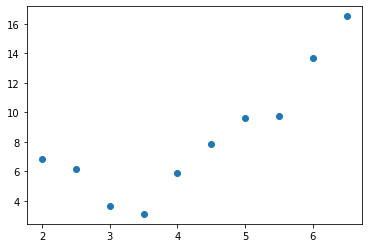

In [17]:
plt.scatter(x_c,dat_c)

Text(0.5, 0, 'sparse size')

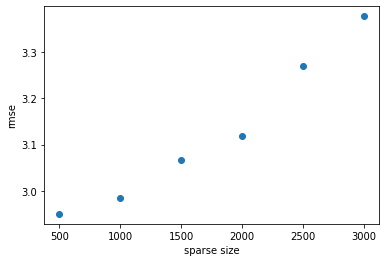

In [23]:
plt.scatter(x_sp, dat_sp)
#interesting?
plt.ylabel('rmse')
plt.xlabel('sparse size')

In [ ]:
plt.scatter(x_k, )